In [1]:
import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt

In [2]:
raw_train_z500 = np.load('../POD_Dataset/train_z500_coeffs.npy').T[:,:]
raw_train_u250 = np.load('../POD_Dataset/train_u250_coeffs.npy').T[:,:]
raw_train_v250 = np.load('../POD_Dataset/train_v250_coeffs.npy').T[:,:]
raw_train_u850 = np.load('../POD_Dataset/train_u850_coeffs.npy').T[:,:]
raw_train_v850 = np.load('../POD_Dataset/train_v850_coeffs.npy').T[:,:]
raw_train_t250 = np.load('../POD_Dataset/train_t250_coeffs.npy').T[:,:]
raw_train_t850 = np.load('../POD_Dataset/train_t850_coeffs.npy').T[:,:]
raw_train_blh = np.load('../POD_Dataset/train_blh_coeffs.npy').T[:,:]
raw_train_tcwv = np.load('../POD_Dataset/train_tcwv_coeffs.npy').T[:,:]


raw_train = np.concatenate((raw_train_z500,
                            raw_train_u250,raw_train_v250,raw_train_t250,
                            raw_train_u850,raw_train_v850,raw_train_t850,
                            raw_train_blh,
                           raw_train_tcwv),axis=-1)

In [3]:
scaler = MinMaxScaler()
train_coeffs = scaler.fit_transform(raw_train)

In [4]:
input_window = 56
output_window = 7

train_inputs = []
train_outputs = []

i = 0
while i < train_coeffs.shape[0] - input_window - output_window:
    train_inputs.append(train_coeffs[i:i+input_window])
    train_outputs.append(train_coeffs[i+input_window:i+input_window+output_window])
    i = i + 1
    
train_inputs = np.asarray(train_inputs)
train_outputs = np.asarray(train_outputs)

In [5]:
embed_dim = train_inputs[0].shape[-1]
output_dim = train_outputs[0].shape[-1]
encode_dim = 180

In [6]:
num_ae_encoder_layers = 3
num_ae_decoder_layers = 3
num_lstm_cells_encoder = 3
num_lstm_cells_decoder = 3

In [7]:
ff_dim = 100  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.0

inputs = layers.Input(shape=(input_window,embed_dim))
ae_encoding_layers = []
for _ in range(num_ae_encoder_layers):
    ae_encoding_layers.append(layers.TimeDistributed(layers.Dense(encode_dim,activation='elu')))

lstm_encoder_cells = []
for _ in range(num_lstm_cells_encoder):
    lstm_encoder_cells.append(layers.Bidirectional(layers.LSTM(ff_dim,activation='elu',return_sequences=True,)))

lstm_encoder_final = layers.Bidirectional(layers.LSTM(ff_dim,activation='elu'))
lstm_repeater_layer = layers.RepeatVector(output_window)
    
lstm_decoder_cells = []
for _ in range(num_lstm_cells_decoder):
    lstm_decoder_cells.append(layers.LSTM(encode_dim,activation='elu',return_sequences=True,))

    
ae_decoding_layers = []
for _ in range(num_ae_decoder_layers):
    ae_decoding_layers.append(layers.TimeDistributed(layers.Dense(embed_dim,activation='elu')))


# Encode from physical space
print('Input shape:',inputs.get_shape().as_list())

x = inputs
for i in range(num_ae_encoder_layers):
    x = ae_encoding_layers[i](x)
encoded = x

print('AE Encoded shape:',encoded.get_shape().as_list())

x = lstm_encoder_cells[0](encoded)    
for i in range(1,num_lstm_cells_encoder):
    x = lstm_encoder_cells[i](x)
    
x = lstm_encoder_final(x)

print('LSTM Encoded shape:',x.get_shape().as_list())

x = lstm_repeater_layer(x)

for i in range(num_lstm_cells_decoder):
    x = lstm_decoder_cells[i](x)

print('LSTM Decoded shape:',x.get_shape().as_list())
    
for i in range(num_ae_decoder_layers):
    x = ae_decoding_layers[i](x)
    
outputs = x

print('AE+LSTM Output shape:',outputs.get_shape().as_list())
    
decoded = encoded
for i in range(num_ae_decoder_layers):
    decoded = ae_decoding_layers[i](decoded)
    
print('AE Output shape:',decoded.get_shape().as_list())

model = tf.keras.Model(inputs=inputs, outputs=[outputs,decoded])

Input shape: [None, 56, 900]
AE Encoded shape: [None, 56, 180]
LSTM Encoded shape: [None, 200]
LSTM Decoded shape: [None, 7, 180]
AE+LSTM Output shape: [None, 7, 900]
AE Output shape: [None, 56, 900]


In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss',patience=20)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mean_squared_error',loss_weights=[1,1])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 900)]    0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 56, 180)      162180      input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 56, 180)      32580       time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 56, 180)      32580       time_distributed_1[0][0]         
______________________________________________________________________________________________

In [10]:
history = model.fit(train_inputs,[train_outputs,train_inputs],epochs=250,batch_size=1000,callbacks=[reduce_lr,early_stop],validation_split=0.2)

Train on 10000 samples, validate on 2501 samples
Epoch 1/250
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.4320 - time_distributed_5_loss: 0.2616 - time_distributed_5_1_loss: 0.1704 - val_loss: 0.3249 - val_time_distributed_5_loss: 0.2499 - val_time_distributed_5_1_loss: 0.0751
Epoch 2/250
10000/10000 [==============================] - 4s 401us/sample - loss: 0.3126 - time_distributed_5_loss: 0.2672 - time_distributed_5_1_loss: 0.0454 - val_loss: 0.2416 - val_time_distributed_5_loss: 0.2176 - val_time_distributed_5_1_loss: 0.0241
Epoch 3/250
10000/10000 [==============================] - 4s 383us/sample - loss: 0.1954 - time_distributed_5_loss: 0.1750 - time_distributed_5_1_loss: 0.0204 - val_loss: 0.1406 - val_time_distributed_5_loss: 0.1200 - val_time_distributed_5_1_loss: 0.0207
Epoch 4/250
10000/10000 [==============================] - 4s 378us/sample - loss: 0.1115 - time_distributed_5_loss: 0.0918 - time_distributed_5_1_loss: 0.0197 - val_loss: 0.0866 - 

Epoch 33/250
10000/10000 [==============================] - 5s 504us/sample - loss: 0.0272 - time_distributed_5_loss: 0.0133 - time_distributed_5_1_loss: 0.0139 - val_loss: 0.0278 - val_time_distributed_5_loss: 0.0136 - val_time_distributed_5_1_loss: 0.0143
Epoch 34/250
10000/10000 [==============================] - 5s 493us/sample - loss: 0.0271 - time_distributed_5_loss: 0.0133 - time_distributed_5_1_loss: 0.0139 - val_loss: 0.0278 - val_time_distributed_5_loss: 0.0136 - val_time_distributed_5_1_loss: 0.0142
Epoch 35/250
10000/10000 [==============================] - 5s 507us/sample - loss: 0.0271 - time_distributed_5_loss: 0.0132 - time_distributed_5_1_loss: 0.0138 - val_loss: 0.0277 - val_time_distributed_5_loss: 0.0136 - val_time_distributed_5_1_loss: 0.0142
Epoch 36/250
10000/10000 [==============================] - 5s 479us/sample - loss: 0.0270 - time_distributed_5_loss: 0.0132 - time_distributed_5_1_loss: 0.0138 - val_loss: 0.0277 - val_time_distributed_5_loss: 0.0136 - val_ti

Epoch 65/250
10000/10000 [==============================] - 5s 452us/sample - loss: 0.0262 - time_distributed_5_loss: 0.0132 - time_distributed_5_1_loss: 0.0131 - val_loss: 0.0269 - val_time_distributed_5_loss: 0.0136 - val_time_distributed_5_1_loss: 0.0134
Epoch 66/250
10000/10000 [==============================] - 5s 451us/sample - loss: 0.0262 - time_distributed_5_loss: 0.0132 - time_distributed_5_1_loss: 0.0130 - val_loss: 0.0269 - val_time_distributed_5_loss: 0.0136 - val_time_distributed_5_1_loss: 0.0134
Epoch 67/250
10000/10000 [==============================] - 5s 495us/sample - loss: 0.0262 - time_distributed_5_loss: 0.0132 - time_distributed_5_1_loss: 0.0130 - val_loss: 0.0268 - val_time_distributed_5_loss: 0.0136 - val_time_distributed_5_1_loss: 0.0134
Epoch 68/250
10000/10000 [==============================] - 5s 488us/sample - loss: 0.0262 - time_distributed_5_loss: 0.0132 - time_distributed_5_1_loss: 0.0130 - val_loss: 0.0268 - val_time_distributed_5_loss: 0.0136 - val_ti

Epoch 97/250
10000/10000 [==============================] - 6s 550us/sample - loss: 0.0256 - time_distributed_5_loss: 0.0131 - time_distributed_5_1_loss: 0.0125 - val_loss: 0.0262 - val_time_distributed_5_loss: 0.0135 - val_time_distributed_5_1_loss: 0.0129
Epoch 98/250
10000/10000 [==============================] - 5s 542us/sample - loss: 0.0255 - time_distributed_5_loss: 0.0130 - time_distributed_5_1_loss: 0.0125 - val_loss: 0.0262 - val_time_distributed_5_loss: 0.0135 - val_time_distributed_5_1_loss: 0.0129
Epoch 99/250
10000/10000 [==============================] - 5s 454us/sample - loss: 0.0255 - time_distributed_5_loss: 0.0130 - time_distributed_5_1_loss: 0.0125 - val_loss: 0.0262 - val_time_distributed_5_loss: 0.0134 - val_time_distributed_5_1_loss: 0.0129
Epoch 100/250
10000/10000 [==============================] - 4s 446us/sample - loss: 0.0255 - time_distributed_5_loss: 0.0130 - time_distributed_5_1_loss: 0.0125 - val_loss: 0.0262 - val_time_distributed_5_loss: 0.0134 - val_t

Epoch 129/250
10000/10000 [==============================] - 5s 483us/sample - loss: 0.0250 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0121 - val_loss: 0.0257 - val_time_distributed_5_loss: 0.0134 - val_time_distributed_5_1_loss: 0.0125
Epoch 130/250
10000/10000 [==============================] - 6s 560us/sample - loss: 0.0250 - time_distributed_5_loss: 0.0130 - time_distributed_5_1_loss: 0.0121 - val_loss: 0.0258 - val_time_distributed_5_loss: 0.0134 - val_time_distributed_5_1_loss: 0.0125
Epoch 131/250
10000/10000 [==============================] - 5s 487us/sample - loss: 0.0250 - time_distributed_5_loss: 0.0130 - time_distributed_5_1_loss: 0.0121 - val_loss: 0.0257 - val_time_distributed_5_loss: 0.0134 - val_time_distributed_5_1_loss: 0.0124
Epoch 132/250
10000/10000 [==============================] - 4s 391us/sample - loss: 0.0250 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0120 - val_loss: 0.0257 - val_time_distributed_5_loss: 0.0134 - va

Epoch 161/250
10000/10000 [==============================] - 4s 397us/sample - loss: 0.0246 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0117 - val_loss: 0.0253 - val_time_distributed_5_loss: 0.0133 - val_time_distributed_5_1_loss: 0.0121
Epoch 162/250
10000/10000 [==============================] - 4s 449us/sample - loss: 0.0246 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0117 - val_loss: 0.0253 - val_time_distributed_5_loss: 0.0133 - val_time_distributed_5_1_loss: 0.0121
Epoch 163/250
10000/10000 [==============================] - 5s 459us/sample - loss: 0.0246 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0117 - val_loss: 0.0253 - val_time_distributed_5_loss: 0.0133 - val_time_distributed_5_1_loss: 0.0121
Epoch 164/250
10000/10000 [==============================] - 5s 458us/sample - loss: 0.0246 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0117 - val_loss: 0.0253 - val_time_distributed_5_loss: 0.0133 - va

Epoch 193/250
10000/10000 [==============================] - 5s 495us/sample - loss: 0.0243 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0114 - val_loss: 0.0250 - val_time_distributed_5_loss: 0.0133 - val_time_distributed_5_1_loss: 0.0118
Epoch 194/250
10000/10000 [==============================] - 4s 415us/sample - loss: 0.0243 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0114 - val_loss: 0.0250 - val_time_distributed_5_loss: 0.0133 - val_time_distributed_5_1_loss: 0.0118
Epoch 195/250
10000/10000 [==============================] - 4s 393us/sample - loss: 0.0243 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0114 - val_loss: 0.0250 - val_time_distributed_5_loss: 0.0133 - val_time_distributed_5_1_loss: 0.0118
Epoch 196/250
10000/10000 [==============================] - 4s 388us/sample - loss: 0.0243 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0114 - val_loss: 0.0250 - val_time_distributed_5_loss: 0.0133 - va

Epoch 225/250
10000/10000 [==============================] - 4s 392us/sample - loss: 0.0240 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0111 - val_loss: 0.0248 - val_time_distributed_5_loss: 0.0133 - val_time_distributed_5_1_loss: 0.0116
Epoch 226/250
10000/10000 [==============================] - 4s 391us/sample - loss: 0.0240 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0111 - val_loss: 0.0248 - val_time_distributed_5_loss: 0.0133 - val_time_distributed_5_1_loss: 0.0116
Epoch 227/250
10000/10000 [==============================] - 4s 385us/sample - loss: 0.0240 - time_distributed_5_loss: 0.0129 - time_distributed_5_1_loss: 0.0111 - val_loss: 0.0247 - val_time_distributed_5_loss: 0.0133 - val_time_distributed_5_1_loss: 0.0116
Epoch 228/250
10000/10000 [==============================] - 4s 393us/sample - loss: 0.0240 - time_distributed_5_loss: 0.0128 - time_distributed_5_1_loss: 0.0111 - val_loss: 0.0247 - val_time_distributed_5_loss: 0.0133 - va

### Visualization

In [11]:
pred_outputs, decoded_outputs = model.predict(train_inputs)

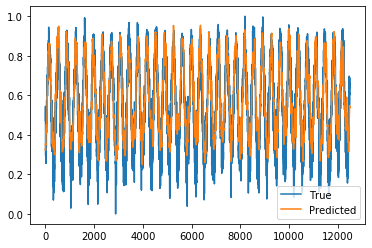

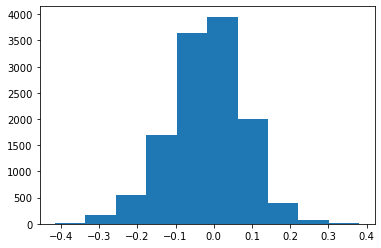

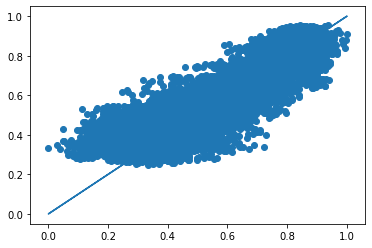

In [12]:
mode_num = 0
lead_time = 6

true_series = []
pred_series = []

for i in range(pred_outputs.shape[0]):
    true_series.append(train_outputs[i,lead_time,mode_num])
    pred_series.append(pred_outputs[i,lead_time,mode_num])

    
true_series = np.asarray(true_series)
pred_series = np.asarray(pred_series)

plt.figure()
plt.plot(true_series,label='True')
plt.plot(pred_series,label='Predicted')
plt.legend()
plt.show()

plt.figure()
plt.hist(np.asarray(true_series-pred_series))
plt.show()

plt.figure()
plt.plot(true_series,true_series)
plt.scatter(true_series,pred_series)
plt.show()

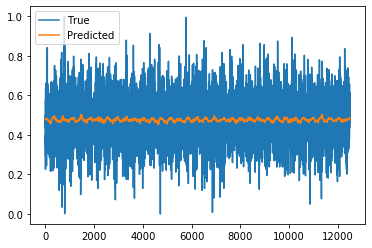

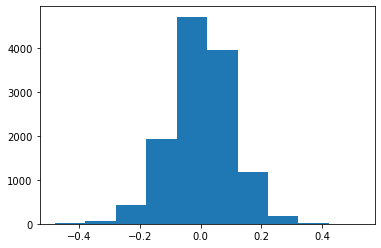

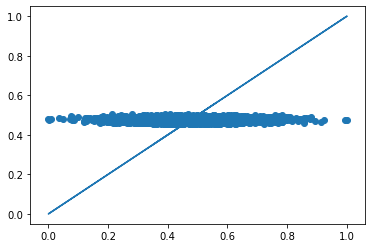

In [13]:
mode_num = 20
lead_time = 6

true_series = []
pred_series = []

for i in range(pred_outputs.shape[0]):
    true_series.append(train_outputs[i,lead_time,mode_num])
    pred_series.append(pred_outputs[i,lead_time,mode_num])

    
true_series = np.asarray(true_series)
pred_series = np.asarray(pred_series)

plt.figure()
plt.plot(true_series,label='True')
plt.plot(pred_series,label='Predicted')
plt.legend()
plt.show()

plt.figure()
plt.hist(np.asarray(true_series-pred_series))
plt.show()

plt.figure()
plt.plot(true_series,true_series)
plt.scatter(true_series,pred_series)
plt.show()

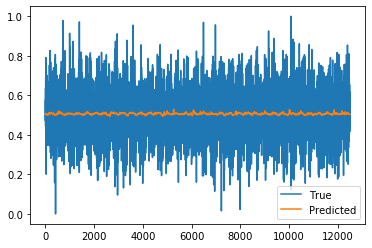

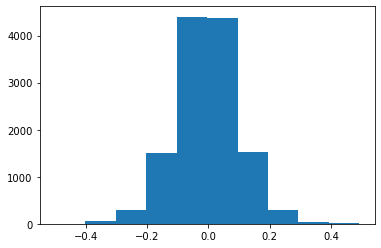

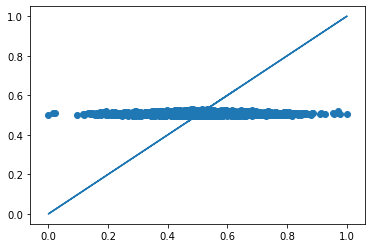

In [14]:
mode_num = 40
lead_time = 6

true_series = []
pred_series = []

for i in range(pred_outputs.shape[0]):
    true_series.append(train_outputs[i,lead_time,mode_num])
    pred_series.append(pred_outputs[i,lead_time,mode_num])

    
true_series = np.asarray(true_series)
pred_series = np.asarray(pred_series)

plt.figure()
plt.plot(true_series,label='True')
plt.plot(pred_series,label='Predicted')
plt.legend()
plt.show()

plt.figure()
plt.hist(np.asarray(true_series-pred_series))
plt.show()

plt.figure()
plt.plot(true_series,true_series)
plt.scatter(true_series,pred_series)
plt.show()

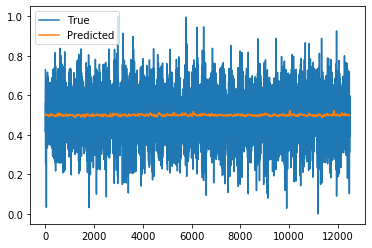

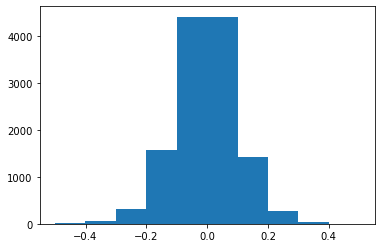

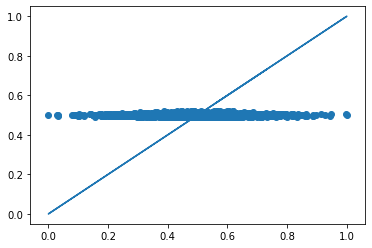

In [15]:
mode_num = 60
lead_time = 6

true_series = []
pred_series = []

for i in range(pred_outputs.shape[0]):
    true_series.append(train_outputs[i,lead_time,mode_num])
    pred_series.append(pred_outputs[i,lead_time,mode_num])

    
true_series = np.asarray(true_series)
pred_series = np.asarray(pred_series)

plt.figure()
plt.plot(true_series,label='True')
plt.plot(pred_series,label='Predicted')
plt.legend()
plt.show()

plt.figure()
plt.hist(np.asarray(true_series-pred_series))
plt.show()

plt.figure()
plt.plot(true_series,true_series)
plt.scatter(true_series,pred_series)
plt.show()